# Apply LSTM to predict price and sales and look for possible connections


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import MultipleLocator

## 创建单个港口每日销量表
选择出现最多的营口-宁波航线

In [86]:

date_csv_deal = pd.read_csv('Yingkou_Ningbo_AMT.csv')


## 数据预处理

In [87]:
# 数据预处理
#date_csv = date_csv.dropna()
#dataset = date_csv.values
#dataset = dataset.astype('float32')
#max_value = np.max(dataset)  # 获得最大值
#min_value = np.min(dataset)  # 获得最小值
#scalar = max_value - min_value  # 获得间隔数量
#dataset = list(map(lambda x: x / scalar, dataset)) # 归一化

#40w有合约
date_csv_deal = date_csv_deal.dropna()
# dataset_deal = date_csv_deal['sales'].values
dataset_deal = date_csv_deal['AMT'].values
dataset_deal = dataset_deal.astype('float32')
max_value_deal = np.max(dataset_deal)  # 获得最大值
min_value_deal = np.min(dataset_deal)  # 获得最小值
scalar_deal = max_value_deal - min_value_deal  # 获得间隔数量
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset_deal)
dataset_deal = list(map(lambda x: (x - min_value_deal) / scalar_deal, dataset_deal)) # 归一化
print(dataset_deal)


[0.064150855, 0.60682833, 0.42264143, 0.42264143, 0.42264143, 0.42264143, 0.42264143, 0.46567377, 0.43707007, 0.44081047, 0.49666187, 0.5031289, 0.51698107, 0.47385436, 0.45768186, 0.44150934, 0.44150934, 0.44150934, 0.48536474, 0.44150934, 0.45926735, 0.030240096, 0.018867925, 0.018867925, 0.018867925, 0.018867925, 0.018867925, 0.00039088822, 0.023652466, 0.0, 0.0, 0.0, 0.0, 0.053097185, 0.5265488, 1.0, 1.0, 1.0]


## 设置数据集
设置X,Y数据集。以look_back=2为准，取第一个和第二个为数组，形成data_X,取第三个作为预测值，形成data_Y，完成训练集的提取。

In [88]:
def create_dataset(dataset, look_back=7):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

#data_X, data_Y = create_dataset(dataset)
#40w有合约
data_X_deal, data_Y_deal = create_dataset(dataset_deal)
print(data_X_deal)

[[6.4150855e-02 6.0682833e-01 4.2264143e-01 4.2264143e-01 4.2264143e-01
  4.2264143e-01 4.2264143e-01]
 [6.0682833e-01 4.2264143e-01 4.2264143e-01 4.2264143e-01 4.2264143e-01
  4.2264143e-01 4.6567377e-01]
 [4.2264143e-01 4.2264143e-01 4.2264143e-01 4.2264143e-01 4.2264143e-01
  4.6567377e-01 4.3707007e-01]
 [4.2264143e-01 4.2264143e-01 4.2264143e-01 4.2264143e-01 4.6567377e-01
  4.3707007e-01 4.4081047e-01]
 [4.2264143e-01 4.2264143e-01 4.2264143e-01 4.6567377e-01 4.3707007e-01
  4.4081047e-01 4.9666187e-01]
 [4.2264143e-01 4.2264143e-01 4.6567377e-01 4.3707007e-01 4.4081047e-01
  4.9666187e-01 5.0312889e-01]
 [4.2264143e-01 4.6567377e-01 4.3707007e-01 4.4081047e-01 4.9666187e-01
  5.0312889e-01 5.1698107e-01]
 [4.6567377e-01 4.3707007e-01 4.4081047e-01 4.9666187e-01 5.0312889e-01
  5.1698107e-01 4.7385436e-01]
 [4.3707007e-01 4.4081047e-01 4.9666187e-01 5.0312889e-01 5.1698107e-01
  4.7385436e-01 4.5768186e-01]
 [4.4081047e-01 4.9666187e-01 5.0312889e-01 5.1698107e-01 4.7385436e-01
 

## 设置训练集和测试集

In [89]:
# 划分训练集和测试集，70% 作为训练集
#train_size = int(len(data_X) * 0.7)
#test_size = len(data_X) - train_size
#train_X = data_X[:train_size]
#train_Y = data_Y[:train_size]
#test_X = data_X[train_size:]
#test_Y = data_Y[train_size:]

#40w有合约
print(len(data_Y_deal))

# train_size_deal = int(len(data_X_deal) * 0.7)
# test_size_deal = len(data_X_deal) - train_size_deal
train_size_deal = 28
test_size_deal = len(data_X_deal) - train_size_deal

train_X_deal = data_X_deal[:train_size_deal]
train_Y_deal = data_Y_deal[:train_size_deal]

test_X_deal = data_X_deal[train_size_deal:]
test_Y_deal = data_Y_deal[train_size_deal:]
print(test_X_deal)
print(test_Y_deal)

31
[[0.02365247 0.         0.         0.         0.         0.05309718
  0.5265488 ]
 [0.         0.         0.         0.         0.05309718 0.5265488
  1.        ]
 [0.         0.         0.         0.05309718 0.5265488  1.
  1.        ]]
[1. 1. 1.]


## 设置LSTM模型数据类型形状
设置LSTM能识别的数据类型，形成train_X的一维两个参数的数组，train_Y的一维一个参数的数组。并转化为tensor类型

In [90]:
import torch

#train_X = train_X.reshape(-1, 1, 2)
#train_Y = train_Y.reshape(-1, 1, 1)
#test_X = test_X.reshape(-1, 1, 2)

#train_x = torch.from_numpy(train_X)
#train_y = torch.from_numpy(train_Y)
#test_x = torch.from_numpy(test_X)

#40w有合约
train_X_deal = train_X_deal.reshape(-1, 1, 7)
train_Y_deal = train_Y_deal.reshape(-1, 1, 1)
test_X_deal = test_X_deal.reshape(-1, 1, 7)


train_x_deal = torch.from_numpy(train_X_deal)
train_y_deal = torch.from_numpy(train_Y_deal)
test_x_deal = torch.from_numpy(test_X_deal)
#test_y_deal = torch.from_numpy(test_Y_deal)
print(test_Y_deal)

[1. 1. 1.]


## 建立LSTM模型
建立LSTM模型，第一层为LSTM神经网络，第二层为一个全连接层。

In [91]:
from torch import nn
from torch.autograd import Variable

class lstm(nn.Module):
    def __init__(self,input_size=5,hidden_size=20,output_size=1,num_layer=7):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        s,b,h = x.size()
        x = x.view(s*b,h)
        x = self.layer2(x)
        x = x.view(s,b,-1)
        return x

#model = lstm(2,10,1,3)
#40w有合约
model_deal = lstm(7,16,1,3)

## 建立损失函数和优化器
设置交叉熵损失函数和自适应梯度下降算法

In [92]:
#criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

criterion_deal = nn.MSELoss()
optimizer_deal = torch.optim.Adam(model_deal.parameters(), lr=1e-2)

## 模型训练

In [93]:
# 开始训练
#for e in range(100):
#    var_x = Variable(train_x)
#    var_y = Variable(train_y)
    # 前向传播
#    out = model(var_x)
#    loss = criterion(out, var_y)
    # 反向传播
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()
    
#    if (e + 1) % 1000 == 0: # 每 100 次输出结果
#        print(f"Epoch: {e + 1}, Loss: {loss.item()}")

#40w有合约
for e in range(2000):
    var_x_deal = Variable(train_x_deal)
    var_y_deal = Variable(train_y_deal)
    # 前向传播
    out_deal = model_deal(var_x_deal)
    loss_deal = criterion_deal(out_deal, var_y_deal)
    # 反向传播
    optimizer_deal.zero_grad()
    loss_deal.backward()
    optimizer_deal.step()
    
    if (e + 1) % 200 == 0: # 每 100 次输出结果
        print(f"Epoch: {e + 1}, Loss: {loss_deal.item()}")

Epoch: 200, Loss: 0.00045364530524238944
Epoch: 400, Loss: 0.019917750731110573
Epoch: 600, Loss: 0.0001188103124150075
Epoch: 800, Loss: 8.17530817585066e-05
Epoch: 1000, Loss: 6.029303040122613e-05
Epoch: 1200, Loss: 3.986168667324819e-05
Epoch: 1400, Loss: 3.121472036582418e-05
Epoch: 1600, Loss: 2.7529013095772825e-05
Epoch: 1800, Loss: 2.4646331439726055e-05
Epoch: 2000, Loss: 0.010017563588917255


## 模型预测

In [94]:
#model = model.eval() # 转换成测试模式

#data_X = data_X.reshape(-1, 1, 2)
#data_X = torch.from_numpy(data_X)
#var_data = Variable(data_X)
#pred_test = model(var_data) # 测试集的预测结果
# 改变输出的格式
#pred_test = pred_test.view(-1).data.numpy()

#40w有合约
model_deal = model_deal.eval() # 转换成测试模式

#data_X_deal_np = data_X_deal.reshape(-1, 1, 5)
#data_X_deal_tensor = torch.from_numpy(data_X_deal_np)
#var_data_deal = Variable(data_X_deal_tensor)
#pred_test_deal = model_deal(var_data_deal) # 测试集的预测结果
pred_test_deal = model_deal(test_x_deal)
# 改变输出的格式
pred_test_deal = pred_test_deal.view(-1).data.numpy()
pred_test_deal = list(map(lambda x : x * scalar_deal + min_value_deal, pred_test_deal))
real_deal = test_Y_deal

real_deal = list(map(lambda x : x * scalar_deal + min_value_deal, real_deal))
print(real_deal)


[2094.75, 2094.75, 2094.75]


## 预测序列可视化

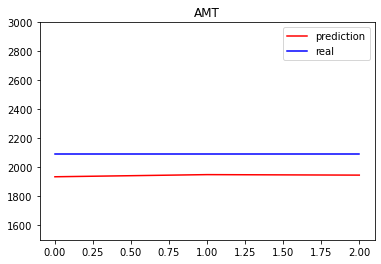

In [95]:
# 画出实际结果和预测的结果
#plt.plot(pred_test, 'r', label='prediction')
#plt.plot(dataset, 'b', label='real')
#plt.legend(loc='best')

#40w有合约
plt.title('AMT')
plt.plot(pred_test_deal, 'r', label='prediction')
plt.plot(real_deal, 'b', label='real')
#ymajorLocator  = MultipleLocator(100)
#ax=plt.gca()
#ax.yaxis.set_major_locator(ymajorLocator)

plt.ylim(1500,3000)
plt.legend(loc='best')
plt.savefig('Yingkou_Ningbo_AMT_new1.png')